In [1]:
import matplotlib.pyplot as plt
import us as usStates
import pandas as pd
from datetime import datetime, timedelta

%matplotlib inline

In [2]:
path_submission_file = '2021-01-18-UCSD_NEU-DeepGLEAM.csv'
df_submission1 = pd.read_csv(path_submission_file)

path_submission_file = '2021-01-18-MOBS-GLEAM_COVID.csv'
df_submission2 = pd.read_csv(path_submission_file)
df_submission2 = df_submission2.sort_values(by=['location','target','quantile'])


last_sat = datetime.strptime(df_submission1.target_end_date.min(), '%Y-%m-%d') - timedelta(7)
timeline = [(last_sat+timedelta(7*i)).strftime('%Y-%m-%d') for i in range(-10,5)]

## states

incidence

In [3]:
## surveillance
df = pd.read_csv('../data/time_series_covid19_deaths_US.csv')
df1 = df.drop(['UID', 'iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key','Population'], axis=1)
df2 = df1.groupby(df1['Province_State']).aggregate('sum')
df2 = df2.drop(['District of Columbia','American Samoa','Guam','Northern Mariana Islands','Virgin Islands','Puerto Rico','Grand Princess','Diamond Princess'],axis = 0)
# groundtruth = df2.diff(axis=1).to_numpy().T[-7:]
df2 = df2.reset_index()
df2 = df2.rename({'Province_State': 'state'}, axis=1)
df2 = df2.melt('state', var_name='date', value_name='deaths')
df2['date'] = pd.to_datetime(df2.date)
df_surveillance = df2.astype({'date': 'str'})

In [5]:
df_submission1

,forecast_date,target,target_end_date,location,type,quantile,value
0,2021-01-18,1 wk ahead cum death,2021-01-23,01,quantile,0.010,6428.081848
1,2021-01-18,1 wk ahead cum death,2021-01-23,01,quantile,0.025,6491.733395
2,2021-01-18,1 wk ahead cum death,2021-01-23,01,quantile,0.050,6524.282482
3,2021-01-18,1 wk ahead cum death,2021-01-23,01,quantile,0.100,6561.791429
4,2021-01-18,1 wk ahead cum death,2021-01-23,01,quantile,0.150,6587.210715
...,...,...,...,...,...,...,...
9787,2021-01-18,4 wk ahead inc death,2021-02-13,US,quantile,0.900,31307.272433
9788,2021-01-18,4 wk ahead inc death,2021-02-13,US,quantile,0.950,33177.341466
9789,2021-01-18,4 wk ahead inc death,2021-02-13,US,quantile,0.975,34800.128643
9790,2021-01-18,4 wk ahead inc death,2021-02-13,US,quantile,0.990,37973.579124


In [6]:
timeline

['2020-11-07',
 '2020-11-14',
 '2020-11-21',
 '2020-11-28',
 '2020-12-05',
 '2020-12-12',
 '2020-12-19',
 '2020-12-26',
 '2021-01-02',
 '2021-01-09',
 '2021-01-16',
 '2021-01-23',
 '2021-01-30',
 '2021-02-06',
 '2021-02-13']

KeyError: "['2020-11-07', '2020-12-05', '2020-12-12', '2021-01-02', '2021-01-09'] not in index"

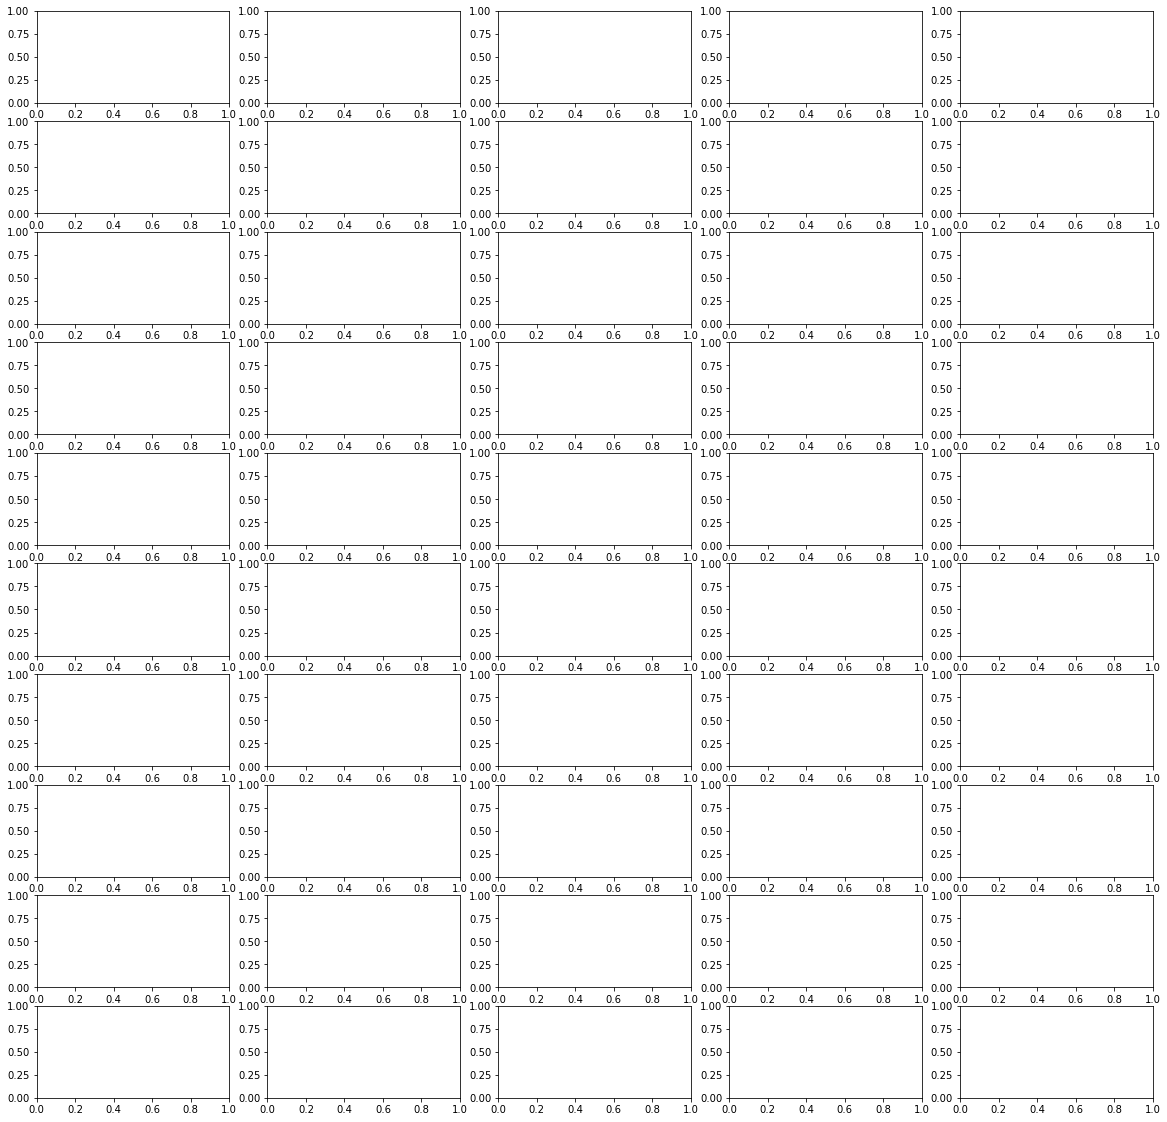

In [4]:
inc_idx = ['inc' in df_submission1.target[i] for i in df_submission1.index]
state_fips_list = [x for x in df_submission1.location.unique() if x!='US']


f, axes = plt.subplots(10, 5, figsize=(20, 20))

for i_state, state_fips in enumerate(state_fips_list):
    i_ax, j_ax = int(i_state/axes.shape[1]), i_state%axes.shape[1]
    ax = axes[i_ax][j_ax]
    state_name = usStates.states.lookup(state_fips).name
    
    ## surveillance
    df_tmp = df_surveillance[df_surveillance.state==state_name]
    df_tmp.index = df_tmp.date
    y_surveillance = df_tmp.deaths[timeline[:-4]].diff()[1:].values
    ax.plot(y_surveillance, 'k^-')
    
    ## prediction
    x_pred = range(len(y_surveillance), len(y_surveillance)+4)
    # median
    df_tmp = df_submission1[(df_submission1.location==state_fips) & inc_idx & (df_submission1['quantile']==0.5)]
    df_tmp.index = df_tmp.target_end_date
    ax.plot(x_pred, df_tmp.value[sorted(df_tmp.index)], label='median')
    
    # point estimate
    df_tmp = df_submission1[(df_submission1.location==state_fips) & inc_idx & (df_submission1['type']=='point')]
    df_tmp.index = df_tmp.target_end_date
    ax.plot(x_pred, df_tmp.value[sorted(df_tmp.index)], label='point estimate')
    
    # 95% CI
    df_tmp = df_submission1[(df_submission1.location==state_fips) & inc_idx & (df_submission1['quantile']==0.975)]
    df_tmp.index = df_tmp.target_end_date
    y_upper = df_tmp.value[sorted(df_tmp.index)]
    
    df_tmp = df_submission1[(df_submission1.location==state_fips) & inc_idx & (df_submission1['quantile']==0.025)]
    df_tmp.index = df_tmp.target_end_date
    y_lower = df_tmp.value[sorted(df_tmp.index)]   
    ax.fill_between(x_pred, y_upper, y_lower, alpha=0.3, label='95% CI')
    

    ## settings
    ax.set_title( state_name )
    
f.tight_layout()

In [ ]:
inc_idx = ['inc' in df_submission2.target[i] for i in df_submission2.index]
state_fips_list = [x for x in df_submission2.location.unique() if x!='US']


f, axes = plt.subplots(10, 5, figsize=(20, 20))

for i_state, state_fips in enumerate(state_fips_list):
    i_ax, j_ax = int(i_state/axes.shape[1]), i_state%axes.shape[1]
    ax = axes[i_ax][j_ax]
    state_name = usStates.states.lookup(state_fips).name
    
    ## surveillance
    df_tmp = df_surveillance[df_surveillance.state==state_name]
    df_tmp.index = df_tmp.date
    y_surveillance = df_tmp.deaths[timeline[:-4]].diff()[1:].values
    ax.plot(y_surveillance, 'k^-')
    
    ## prediction
    x_pred = range(len(y_surveillance), len(y_surveillance)+4)
    # median
    df_tmp = df_submission2[(df_submission2.location==state_fips) & inc_idx & (df_submission2['quantile']==0.5)]
    df_tmp.index = df_tmp.target_end_date
    ax.plot(x_pred, df_tmp.value[sorted(df_tmp.index)], 'red', label='median')
    
    # point estimate
    df_tmp = df_submission2[(df_submission2.location==state_fips) & inc_idx & (df_submission2['type']=='point')]
    df_tmp.index = df_tmp.target_end_date
    ax.plot(x_pred, df_tmp.value[sorted(df_tmp.index)], 'blue', label='point estimate')
    
    # 95% CI
    df_tmp = df_submission2[(df_submission2.location==state_fips) & inc_idx & (df_submission2['quantile']==0.975)]
    df_tmp.index = df_tmp.target_end_date
    y_upper = df_tmp.value[sorted(df_tmp.index)]
    
    df_tmp = df_submission2[(df_submission2.location==state_fips) & inc_idx & (df_submission2['quantile']==0.025)]
    df_tmp.index = df_tmp.target_end_date
    y_lower = df_tmp.value[sorted(df_tmp.index)]   
    ax.fill_between(x_pred, y_upper, y_lower, alpha=0.3, label='95% CI')
    

    ## settings
    ax.set_title( state_name )
    
f.tight_layout()

In [ ]:
inc_idx = ['inc' in df_submission2.target[i] for i in df_submission2.index]
# state_fips_list = [x for x in df_submission2.location.unique() if x=='US']
# state_fips_list
f, ax = plt.subplots(figsize=(10, 10))

# df_tmp = df_surveillance[df_surveillance.state=='US']
# df_tmp
# df_tmp.index = df_tmp.date
# y_surveillance = df_tmp.deaths[timeline[:-4]].diff()[1:].values
# ax.plot(y_surveillance, 'k^-')

x_pred = range(0, 4)
# median
df_tmp = df_submission2[(df_submission2.location=='US') & inc_idx & (df_submission2['quantile']==0.5)]
df_tmp.index = df_tmp.target_end_date
ax.plot(x_pred, df_tmp.value[sorted(df_tmp.index)], label='median')

# 95% CI
df_tmp = df_submission2[(df_submission2.location=='US') & inc_idx & (df_submission2['quantile']==0.975)]
df_tmp.index = df_tmp.target_end_date
y_upper = df_tmp.value[sorted(df_tmp.index)]

df_tmp = df_submission2[(df_submission2.location=='US') & inc_idx & (df_submission2['quantile']==0.025)]
df_tmp.index = df_tmp.target_end_date
y_lower = df_tmp.value[sorted(df_tmp.index)]   
ax.fill_between(x_pred, y_upper, y_lower, alpha=0.3, label='95% CI')